In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Для тепловых карт
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from MLP_lib import MLP, sig_f, tanh_f, visualize_weights_with_biases, Metrics, roc_curve_manual

plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

In [2]:
from sklearn.datasets import fetch_openml
# Загружаем датасет MNIST из OpenML (70000 примеров, 784 признака - это 28*28)
dmf = fetch_openml('mnist_784', version=1)


In [3]:
# 1. Загрузка данных
X, y = dmf["data"], dmf["target"]
# 3. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Преобразование меток y в формат one-hot
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(pd.DataFrame(y))
y_one_hot[y_one_hot == 0] = -1

# 5. Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)

y_train_class = encoder.inverse_transform(y_train)
y_test_class = encoder.inverse_transform(y_test)

In [4]:
# Проверим формы данных
print(f"Форма данных: {X_train.shape}")
print(f"Форма меток: {y_train.shape}")

Форма данных: (49000, 784)
Форма меток: (49000, 10)


In [5]:
 # Преобразуем X из плоских векторов (784,) в формат (28, 28) изображения
X_2 = dmf["data"].values.reshape(-1, 28, 28)

# Проверим формы данных после преобразования
print(f"Форма данных для сверточной сети: {X_2.shape}")

Форма данных для сверточной сети: (70000, 28, 28)


3


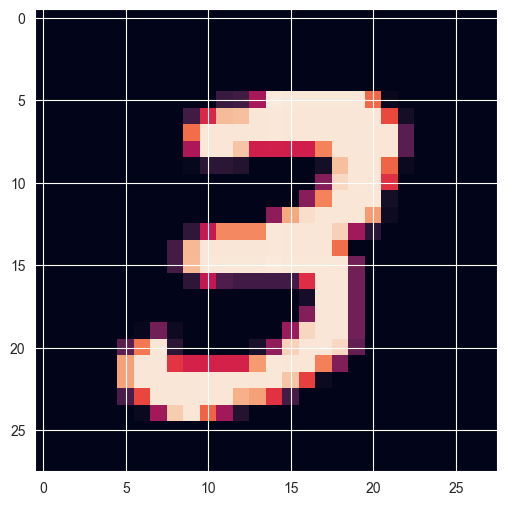

In [6]:
i = 7
plt.imshow(X_2[i])
print((y[i]))

# Используем модель

In [7]:
net_arch_mnist = (X_test.shape[1], 500, 50, 10)
mlp_mnist = MLP(net_arch_mnist, fn=tanh_f, is_need_f_final=True)

In [8]:
epochs = 10
loss_epoches, dW_epoches, loss_test_epoches = mlp_mnist.train(X_train, y_train, epochs=epochs, lr=0.01, X_test=X_test, y_test=y_test, batch_size=128)

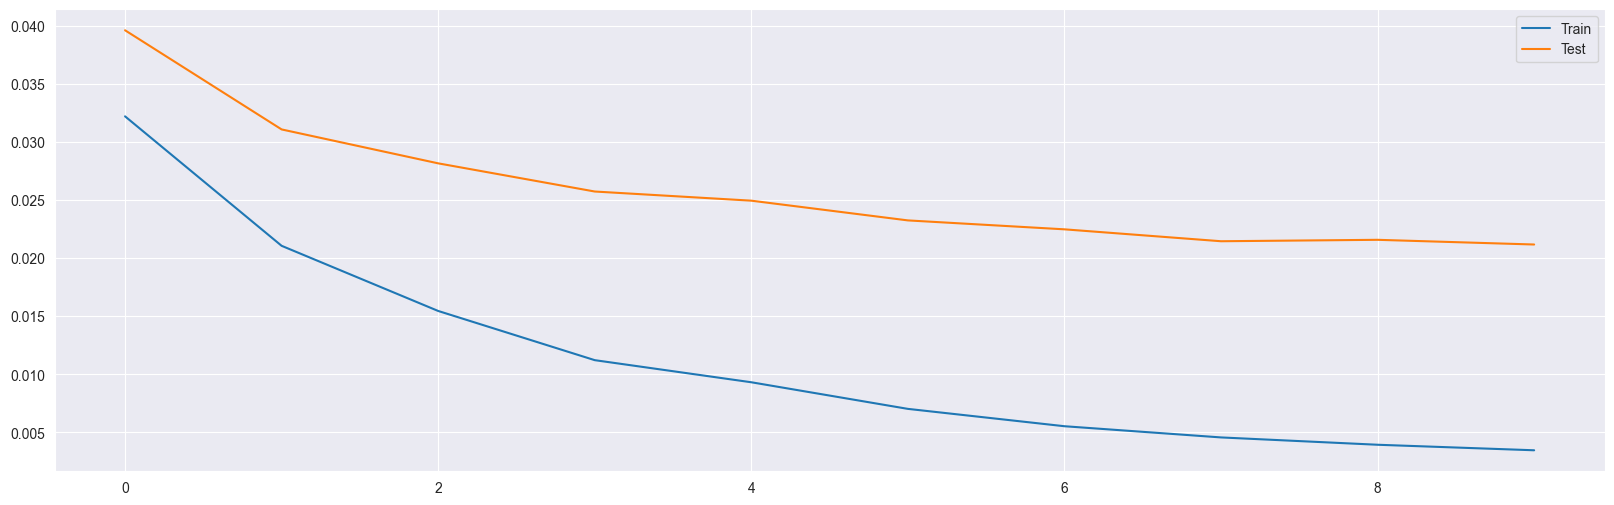

In [9]:
plt.plot(loss_epoches, label='Train')
plt.plot(loss_test_epoches, label='Test')
plt.legend(loc='upper right')
plt.show()

In [10]:
res = mlp_mnist.predict(X_test).T
print('Входящие данные\n',X_test, y_test)
print('Результат:\n',res)
print('Loss\n', mlp_mnist.compute_loss(X_test, y_test))

Входящие данные
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[-1. -1. -1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  1. -1.]
 ...
 [-1. -1.  1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
Результат:
 [[-0.99997916 -0.99999941 -0.9991374  ... -0.99960488 -0.9999996
  -0.99951725]
 [-0.99995903 -0.99902124 -0.99994214 ... -0.99996293 -0.9908206
  -0.99541573]
 [-0.99786809 -0.99997552 -0.99998077 ...  0.99466121 -0.99990544
  -0.99999616]
 ...
 [-0.99999844 -0.95379172 -0.99999262 ... -0.99522196 -0.98249508
  -0.96583559]
 [ 0.99444752 -0.9997088   0.68679377 ... -0.9996942  -0.99990757
  -0.99998807]
 [-0.99365662 -0.99574563 -0.99243159 ... -0.9999999  -0.9873831
  -0.9350814 ]]
Loss
 0.021176479176926347


# Расчет метрик

In [11]:
res_proba = mlp_mnist.predict(X_test, True)

In [12]:
y_test_class

array([['8'],
       ['4'],
       ['8'],
       ...,
       ['2'],
       ['4'],
       ['5']], dtype=object)

In [13]:
y_test_class = y_test_class.astype(np.uint8)

In [14]:
metrics = Metrics(res_proba, y_test_class)
pd.DataFrame(metrics.confusion_matrix)

Class 0: Precision = 0.9781, Recall = 0.9791, F1-Score = 0.9786
Class 1: Precision = 0.9865, Recall = 0.9798, F1-Score = 0.9831
Class 2: Precision = 0.9644, Recall = 0.9635, F1-Score = 0.9639
Class 3: Precision = 0.9577, Recall = 0.9653, F1-Score = 0.9615
Class 4: Precision = 0.9752, Recall = 0.9584, F1-Score = 0.9667
Class 5: Precision = 0.9645, Recall = 0.9660, F1-Score = 0.9652
Class 6: Precision = 0.9804, Recall = 0.9724, F1-Score = 0.9764
Class 7: Precision = 0.9755, Recall = 0.9606, F1-Score = 0.9680
Class 8: Precision = 0.9533, Recall = 0.9679, F1-Score = 0.9605
Class 9: Precision = 0.9435, Recall = 0.9676, F1-Score = 0.9554


,0,1,2,3,4,5,6,7,8,9
0,2013.0,0.0,5.0,7.0,2.0,2.0,7.0,2.0,7.0,11.0
1,1.0,2332.0,13.0,2.0,4.0,2.0,2.0,8.0,10.0,6.0
2,4.0,12.0,2057.0,16.0,6.0,5.0,7.0,14.0,10.0,4.0
3,1.0,7.0,9.0,2084.0,1.0,21.0,1.0,5.0,17.0,13.0
4,4.0,3.0,9.0,1.0,1888.0,3.0,9.0,12.0,4.0,37.0
5,7.0,1.0,5.0,17.0,1.0,1847.0,9.0,3.0,17.0,5.0
6,17.0,1.0,9.0,0.0,6.0,14.0,2047.0,0.0,11.0,0.0
7,4.0,3.0,13.0,20.0,6.0,4.0,1.0,2193.0,8.0,31.0
8,5.0,2.0,9.0,17.0,2.0,12.0,4.0,1.0,1899.0,11.0
9,2.0,3.0,4.0,12.0,20.0,5.0,1.0,10.0,9.0,1972.0


In [15]:
metrics.accuracy

0.9681904761904762

## ROC-кривая

In [16]:
def calculate_auc(fpr, tpr):
    return np.trapz(tpr, fpr)

AUC для класса 0 : 0.9983496498287082
AUC для класса 1 : 0.9990956635066528
AUC для класса 2 : 0.996582090375218
AUC для класса 3 : 0.9938844546464464
AUC для класса 4 : 0.9989804351935022
AUC для класса 5 : 0.9969142307568654
AUC для класса 6 : 0.9987303313673817
AUC для класса 7 : 0.9981453935542249
AUC для класса 8 : 0.9960272223151867
AUC для класса 9 : 0.9960884218623092


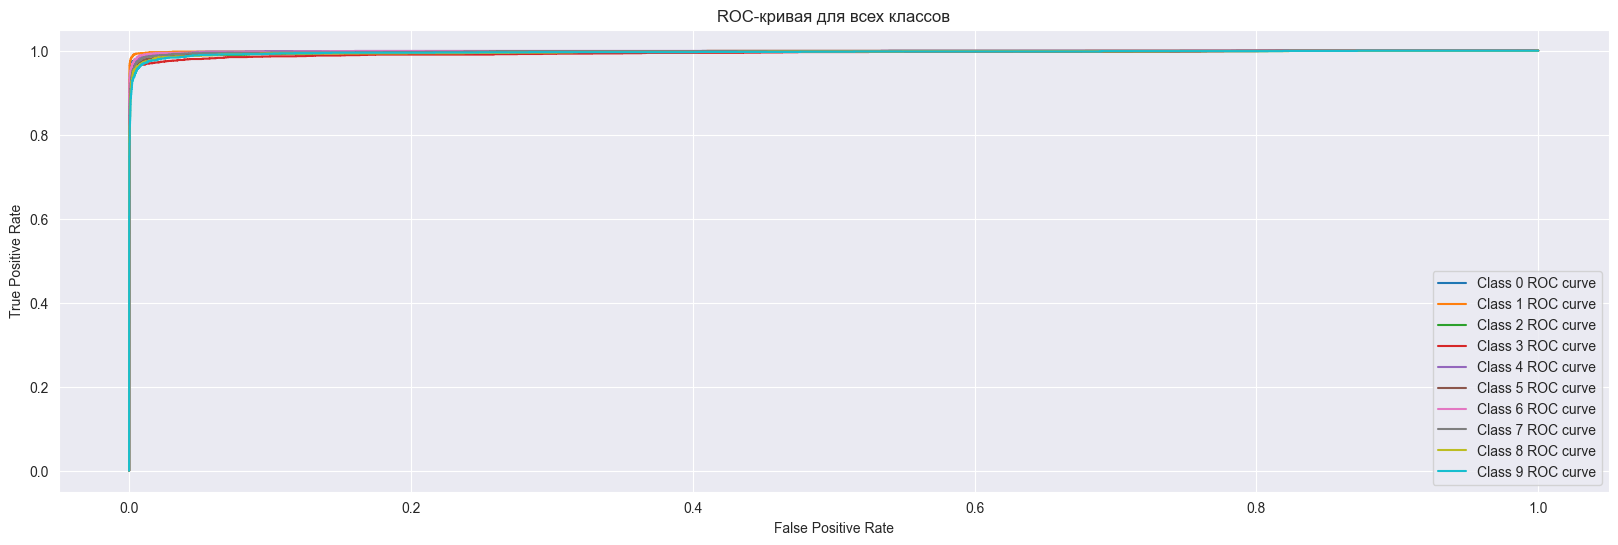

In [17]:
# ROC кривая для класса k
n = 10
y_pred_proba = mlp_mnist.predict_proba(X_test, False)

for i in range(n):
  fpr, tpr = roc_curve_manual(y_test_class, y_pred_proba, i)
  print(f"AUC для класса {i} : {calculate_auc(fpr, tpr)}")
  plt.plot(fpr, tpr, label=f"Class {i} ROC curve")

# Построение ROC-кривой
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.title(f"ROC-кривая для всех классов")
plt.show()